In [1]:
from database.market import Market
from database.sec import SEC
import pandas as pd
import pandas_datareader as pdr
from transformer.date_transformer import DateTransformer
from transformer.column_transformer import ColumnTransformer
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
sec = SEC("sec")
market = Market()

In [3]:
market.connect()
sp500 = market.retrieve_data("sp500")
market.close()

In [12]:
analysis = []
for industry in tqdm(sp500["GICS Sector"].unique()):
    tickers = sp500[sp500["GICS Sector"]==industry]["Symbol"]
    for ticker in tickers:
        try:
            cik = int(sp500[sp500["Symbol"]==ticker]["CIK"])
            sec.connect()
            fm = sec.retrieve_filing_data(cik)
            sec.close()
            market.connect()
            prices = market.retrieve_price_data("pdr_prices",ticker)
            market.close()
            value_analysis = []
            fm.fillna(0,inplace=True)
            p = ColumnTransformer.rename_columns(prices," ")
            p = DateTransformer.convert_to_date("pdr",p,"date")
            fm = ColumnTransformer.rename_columns(fm,"")
#             fm["filed"] = pd.to_datetime(fm["filed"],utc=True)
#             fm.fillna(0,inplace=True)
            for col in fm.columns:
                data = fm[col]
                relevant_values = len([x for x in data if x != 0])
                value_analysis.append({"index":col,"quarters":relevant_values})
            a = pd.DataFrame(value_analysis)
            dates = []
            for date in fm["filed"]:
                try:
                    dc = datetime.strptime(str(date),"%Y%m%d")
                except:
                    dc = datetime.strptime(str(date).split(" ")[0],"%Y-%m-%d")
                dates.append(dc)
            fm["date"] = dates
            fm["quarter"] = [x.quarter for x in fm["date"]]
            fm["year"] = [x.year for x in fm["date"]]
            p["quarter"] = [x.quarter for x in p["date"]]
            p["year"] = [x.year for x in p["date"]]
            p_quarterly = p.groupby(["year","quarter"]).mean().reset_index()
            final = p_quarterly.merge(fm,on=["year","quarter"],how="left").dropna().drop(["year","id","quarter","adsh","date","close","high","open","low"],axis=1,errors="ignore")
            correlations = final.corr()["adjclose"].reset_index().sort_values("adjclose").merge(a,on="index",how="left")
            correlations["adjclose"] = [abs(x) for x in correlations["adjclose"]]
            correlations["industry"] = industry
            correlations["ticker"] = ticker
            analysis.append(correlations.sort_values("adjclose",ascending=False))
        except Exception as e:
            print(ticker,str(e))
            continue

 18%|████████████████████████████████▉                                                                                                                                                    | 2/11 [02:05<09:41, 64.63s/it]

VNT 'filed'


 36%|█████████████████████████████████████████████████████████████████▊                                                                                                                   | 4/11 [03:31<06:00, 51.49s/it]

TIF 't'


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 6/11 [05:12<04:16, 51.34s/it]

FRC 'filed'


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 10/11 [08:25<00:42, 42.38s/it]

CXO 't'


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [08:51<00:00, 48.27s/it]


In [13]:
ic = pd.concat(analysis).fillna(0)
ic_grouped = ic.groupby(["industry","index"]).mean().reset_index().sort_values(["industry","adjclose"],ascending=False)

In [14]:
frequency = []
ic["count"] = 1
frequency = ic.pivot_table(index=["industry","index"],values="count",aggfunc="sum").reset_index()

In [15]:
hehe = ic_grouped.merge(frequency,on=["industry","index"],how="left")

In [16]:
hehe[(hehe["quarters"] > 30) & (hehe["adjclose"] > .60) & (hehe["count"] > 20)].sort_values("adjclose",ascending=False).head(50)

,industry,index,adjclose,quarters,count
90769,Financials,retainedearningsaccumulateddeficit,0.812499,80.666667,63
56260,Industrials,retainedearningsaccumulateddeficit,0.777536,76.783784,74
40052,Information Technology,retainedearningsaccumulateddeficit,0.732895,78.225352,71
40075,Information Technology,liabilities,0.720921,69.763636,55
75064,Health Care,liabilitiesandstockholdersequity,0.711147,78.968254,63
75068,Health Care,assets,0.709380,78.968254,63
75069,Health Care,accountsreceivablenetcurrent,0.709069,74.230769,52
18350,Real Estate,additionalpaidincapital,0.708737,81.272727,22
56372,Industrials,liabilitiesandstockholdersequity,0.705340,79.378378,74
75086,Health Care,additionalpaidincapitalcommonstock,0.699095,68.297297,37


In [17]:
ic = pd.concat(analysis).fillna(0)
ic_grouped = ic.groupby("index").mean().reset_index().sort_values("adjclose",ascending=False)
frequency = []
ic["count"] = 1
frequency = ic.pivot_table(index="index",values="count",aggfunc="sum").reset_index()
hehe = ic_grouped.merge(frequency,on="index",how="left")
hehe[(hehe["quarters"] > 30) & (hehe["adjclose"] > .51) & (hehe["count"] > 300)].sort_values("adjclose",ascending=False).head(50)

,index,adjclose,quarters,count
1894,retainedearningsaccumulateddeficit,0.703973,77.326531,490
2940,liabilitiesandstockholdersequity,0.648308,79.434263,502
2987,assets,0.646820,79.486056,502
3711,additionalpaidincapitalcommonstock,0.618637,64.539474,304
3796,liabilitiescurrent,0.615343,78.026128,421
3834,liabilities,0.613896,72.419444,360
4121,accountsreceivablenetcurrent,0.604800,69.532738,336
4138,treasurystockvalue,0.604183,71.276786,336
4223,propertyplantandequipmentnet,0.601371,75.629474,475
4456,stockholdersequity,0.593848,73.455102,490


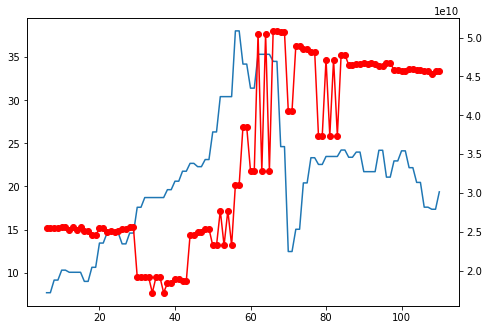

In [18]:
fig = plt.figure()
a1 = fig.add_axes([0,0,1,1])
a1.plot(final["adjclose"])
a2 = a1.twinx()
a2.plot(final["assets"],"ro-")
plt.show()

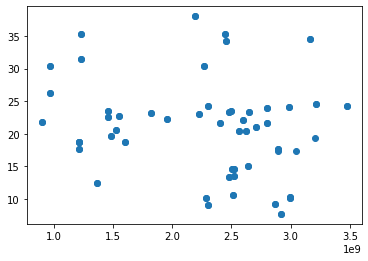

In [22]:
# fig = plt.figure()
# a1 = fig.add_axes([0,0,1,1])
plt.scatter(final["liabilitiescurrent"],final["adjclose"])
# a2 = a1.twinx()
# a2.plot(,"ro-")
plt.show()